## Forecasting Call Volume

Data comes from Data.World's call center data. The file Call_Data.csv is pulled in. Additionally, a SQL query (run in the Data.World environment) of the data is also pulled. 

`select CAST(call_date as DATE), SUM(calls) from call_data
group by CAST(call_date as DATE)
order by CAST(call_date as DATE)`

#### Import Packages

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
%matplotlib inline
plt.style.use('default')

#### Import Data, Rename Columns, Set Index to Datetime

In [2]:
ts_df = pd.read_csv('call-center-test-data-QueryResult.csv')

ts_df.rename(columns = {'call_date':'date', 'sum':'call_v'}, inplace = True)
ts_df['date'] = pd.to_datetime(ts_df['date'])
ts_df = ts_df.set_index('date')
ts_df.reset_index(inplace=True)

ts_df.head()

,date,call_v
0,2017-06-01,535
1,2017-06-02,549
2,2017-06-03,512
3,2017-06-04,294
4,2017-06-05,783


### EDA of Time Series Data (Daily Freq)

In [3]:
date_min = ts_df['date'].min()
date_max = ts_df['date'].max()
print('The data ranges from {} to {}'.format(date_min, date_max))

obs = len(ts_df['date'])
print('There are {} observations'.format(obs))

The data ranges from 2017-06-01 00:00:00 to 2017-08-31 00:00:00
There are 92 observations


#### We have more than 50 observations...shy of 100 plus. Still enough to do our univariate forecasts.

In [4]:
df_mod = ts_df
df_mod['day'] = ts_df['date'].dt.day_name()
df_mod['week'] = ts_df['date'].dt.week

df_mod.head(10)

,date,call_v,day,week
0,2017-06-01,535,Thursday,22
1,2017-06-02,549,Friday,22
2,2017-06-03,512,Saturday,22
3,2017-06-04,294,Sunday,22
4,2017-06-05,783,Monday,23
5,2017-06-06,792,Tuesday,23
6,2017-06-07,510,Wednesday,23
7,2017-06-08,497,Thursday,23
8,2017-06-09,513,Friday,23
9,2017-06-10,478,Saturday,23


In [5]:
df_mod.tail()

,date,call_v,day,week
87,2017-08-27,284,Sunday,34
88,2017-08-28,812,Monday,35
89,2017-08-29,825,Tuesday,35
90,2017-08-30,539,Wednesday,35
91,2017-08-31,573,Thursday,35


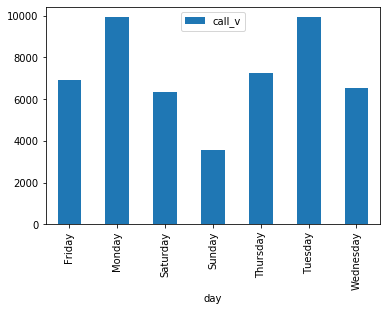

In [9]:
df_mod_1 = df_mod[['call_v', 'day']]

day_freq = df_mod_1.groupby(['day']).sum()

day_freq.plot.bar()

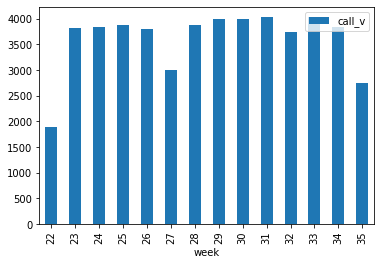

In [10]:
week_freq = df_mod.groupby(['week']).sum()

week_freq.plot.bar()

Not a whole lot of variation by week. We can ignore either end because those weeks were cut-off early.

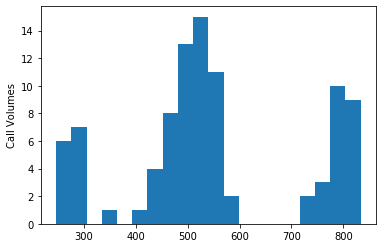

In [12]:
plt.hist(ts_df['call_v'], density=False, bins=20)
plt.ylabel('Call Volumes');

### Plotting

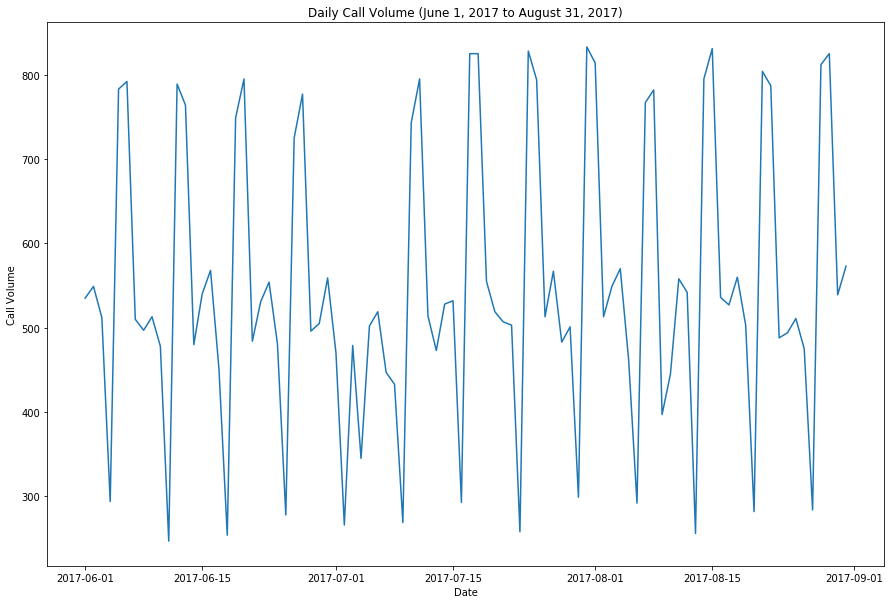

In [13]:
plt.figure(figsize = (15, 10))
plt.plot(ts_df['date'], ts_df['call_v'])
plt.xlabel('Date') 
plt.ylabel('Call Volume') 
plt.title('Daily Call Volume (June 1, 2017 to August 31, 2017)') 

plt.show() 

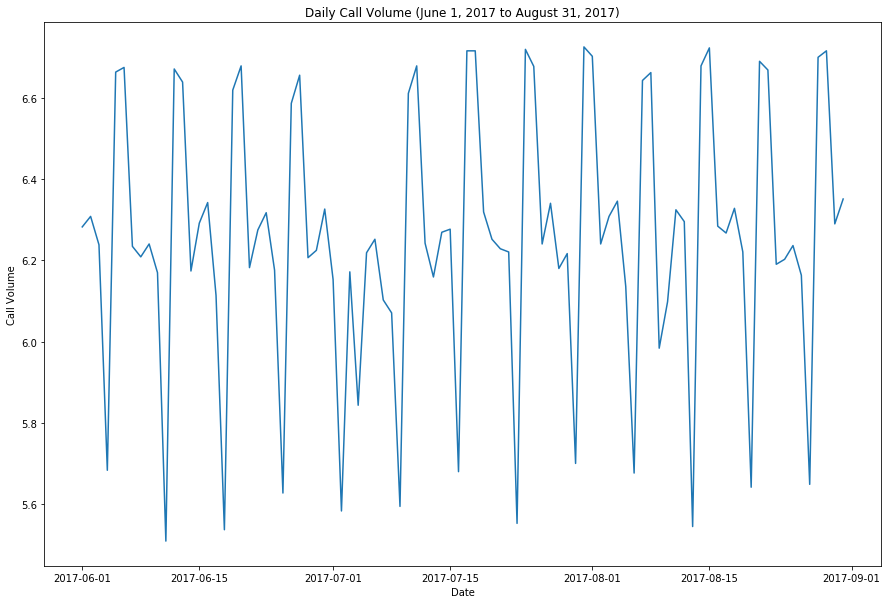

In [14]:
plt.figure(figsize = (15, 10))
plt.plot(ts_df['date'], np.log(ts_df['call_v']))
plt.xlabel('Date') 
plt.ylabel('Call Volume') 
plt.title('Daily Call Volume (June 1, 2017 to August 31, 2017)') 

plt.show() 

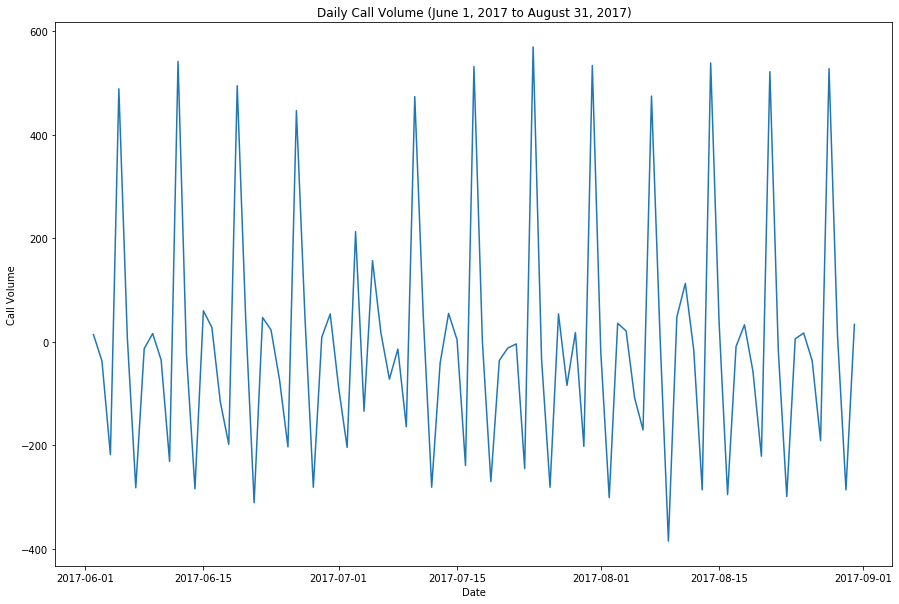

In [15]:
plt.figure(figsize = (15, 10))
plt.plot(ts_df['date'][1:], np.diff((ts_df['call_v'])))
plt.xlabel('Date') 
plt.ylabel('Call Volume') 
plt.title('Daily Call Volume (June 1, 2017 to August 31, 2017)') 

plt.show() 

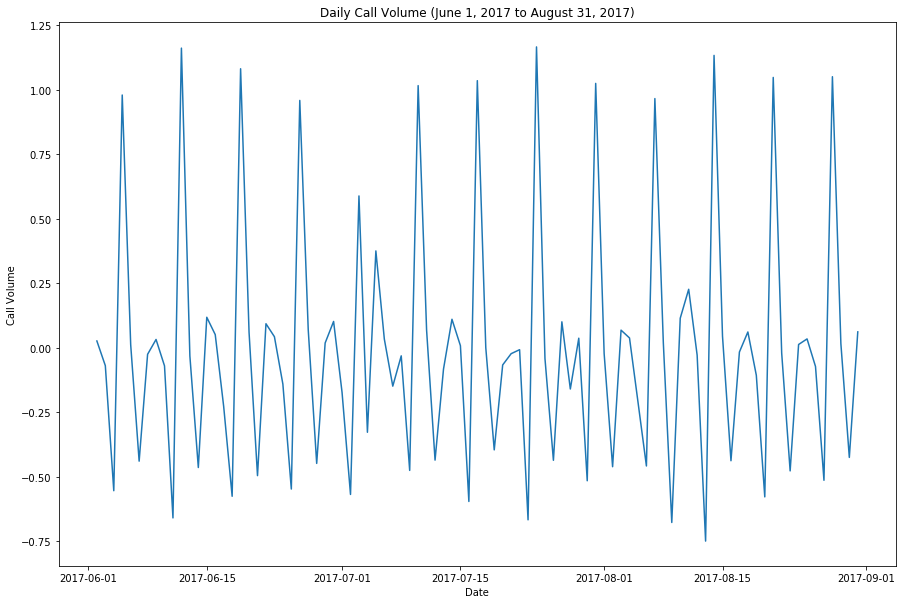

In [16]:
plt.figure(figsize = (15, 10))
plt.plot(ts_df['date'][1:], np.diff(np.log(ts_df['call_v'])))
plt.xlabel('Date') 
plt.ylabel('Call Volume') 
plt.title('Daily Call Volume (June 1, 2017 to August 31, 2017)') 

plt.show() 

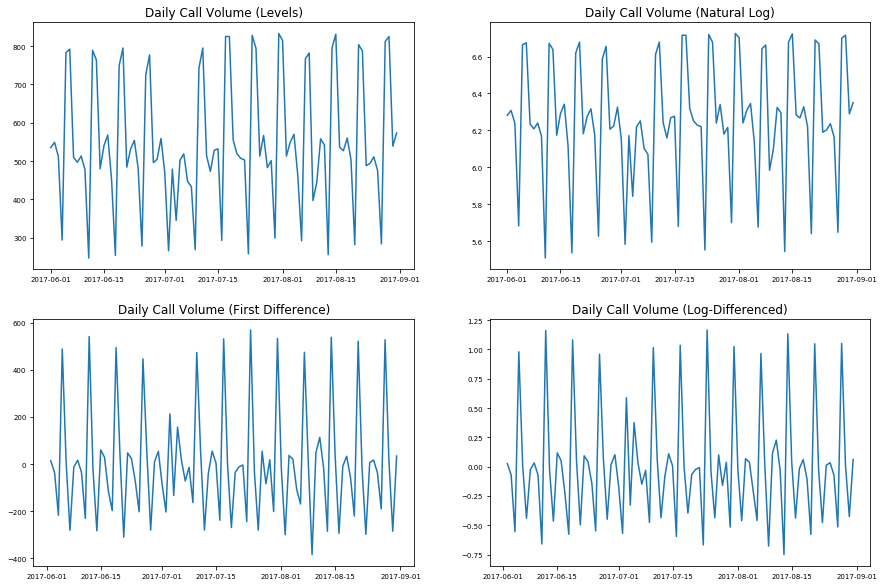

In [17]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 7
matplotlib.rcParams['ytick.labelsize'] = 7

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.plot(ts_df['date'], ts_df['call_v'])
ax1.set_title('Daily Call Volume (Levels)') 

ax2.plot(ts_df['date'], np.log(ts_df['call_v']))
ax2.set_title('Daily Call Volume (Natural Log)') 

ax3.plot(ts_df['date'][1:], np.diff((ts_df['call_v']))) 
ax3.set_title('Daily Call Volume (First Difference)') 

ax4.plot(ts_df['date'][1:], np.diff(np.log(ts_df['call_v'])))
ax4.set_title('Daily Call Volume (Log-Differenced)') 

plt.show()

The data in levels doesn't look terrible, but the first difference looks like a good bet. We can check stationarity w/ ADF and KPSS tests below.

### Stationarity Testing

To get a more accurate test of our ability to forecast call volume, we can split the data into test and train..

In [18]:
ts_df['date'] = pd.to_datetime(ts_df['date'])
ts_df = ts_df.set_index('date')
ts_df.reset_index(inplace=True)
ts_df.drop('day',1, inplace = True)

ts_df.head()

,date,call_v,week
0,2017-06-01,535,22
1,2017-06-02,549,22
2,2017-06-03,512,22
3,2017-06-04,294,22
4,2017-06-05,783,23


In [19]:
train = ts_df[:int(0.7*(len(ts_df['call_v'])))]
test = ts_df[int(0.7*(len(ts_df['call_v']))):]

train.tail()

,date,call_v,week
59,2017-07-30,299,30
60,2017-07-31,833,31
61,2017-08-01,814,31
62,2017-08-02,513,31
63,2017-08-03,549,31


In [20]:
test.head()

,date,call_v,week
64,2017-08-04,570,31
65,2017-08-05,462,31
66,2017-08-06,292,31
67,2017-08-07,767,32
68,2017-08-08,782,32


In [21]:
# Borrowed from Analytics Vidha
# Link: https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag= 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(train['call_v'])

Results of Dickey-Fuller Test:
Test Statistic                 -2.102293
p-value                         0.243594
#Lags Used                      9.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


P-value greater than 0.1, indicates that the series is non-stationary in levels. Let's test it on the first-differenced series.

In [22]:
adf_test(np.diff(train['call_v']))

Results of Dickey-Fuller Test:
Test Statistic                 -2.988777
p-value                         0.035956
#Lags Used                      8.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


Below 0.05.

#### We can auto generate an ARIMA, both R and Python have nice auto-arima functions. They can save us time and if we don't like the results we can always build them by hand.

In [23]:
train.head()

,date,call_v,week
0,2017-06-01,535,22
1,2017-06-02,549,22
2,2017-06-03,512,22
3,2017-06-04,294,22
4,2017-06-05,783,23


Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(1, 1, 1, 7) (constant=True); AIC=674.290, BIC=682.463, Time=0.290 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=True); AIC=693.134, BIC=697.220, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 7) (constant=True); AIC=676.003, BIC=684.175, Time=0.090 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 7) (constant=True); AIC=657.912, BIC=666.084, Time=0.196 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=False); AIC=691.135, BIC=693.178, Time=0.010 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 7) (constant=True); AIC=673.028, BIC=679.157, Time=0.118 seconds
Near non-invertible roots for order (0, 0, 0)(0, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (0, 0, 0)x(1, 1, 0, 7) (constant=True); AIC=685.839, 

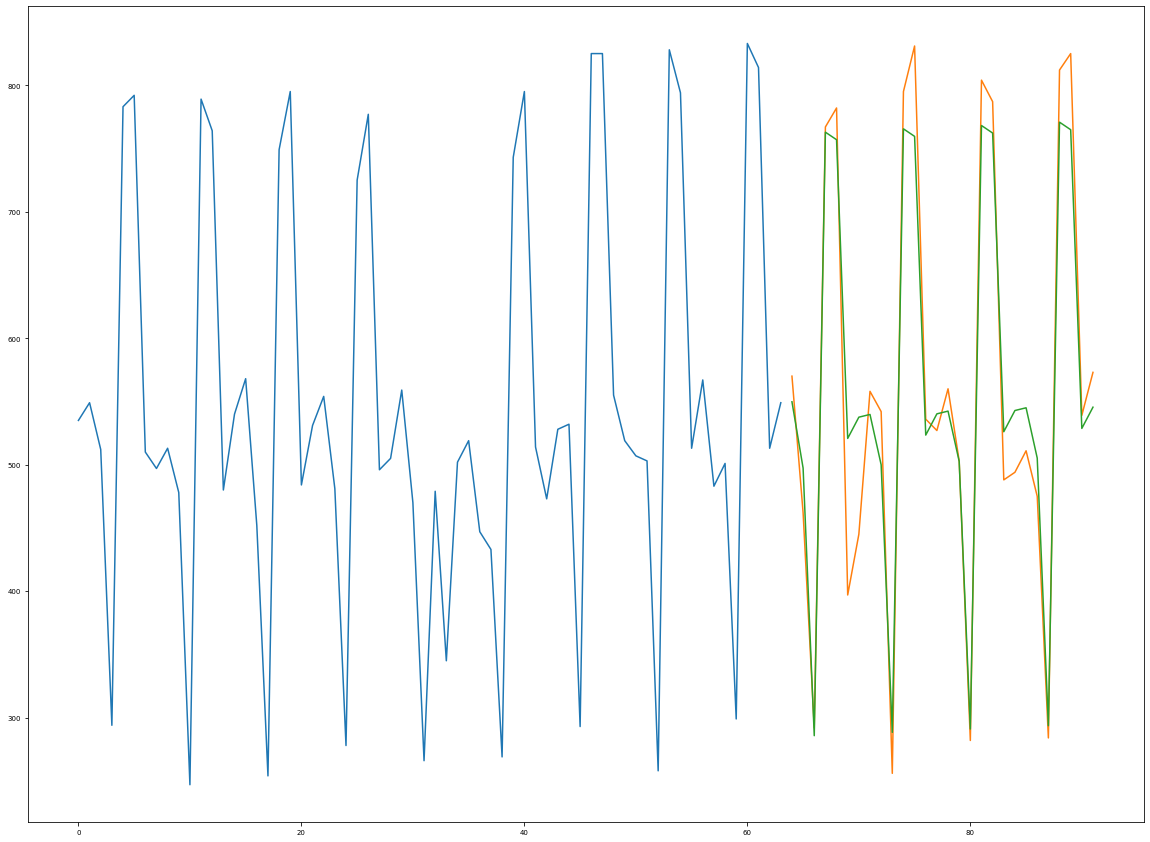

In [33]:
from pmdarima  import auto_arima

sarima_model = auto_arima(train['call_v'], trace = True, start_p = 0, d =0, start_q = 0,
                  max_p = 10, max_q = 10, m = 7, seasonal = True,
                  stepwise = True, suppress_warnings = True)

sarima_model.fit(train['call_v'])

sarima_forecast = sarima_model.predict(n_periods=len(test['call_v']))
sarima_forecast_df = pd.DataFrame(sarima_forecast,index = test['call_v'].index,columns=['Prediction'])

#plot the predictions for validation set
plt.figure(figsize = (20,15))
plt.plot(train['call_v'], label='Train')
plt.plot(test['call_v'], label='Valid')
plt.plot(sarima_forecast_df, label='Prediction')
plt.show()

In [34]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 7)   Log Likelihood                -324.956
Date:                           Sun, 01 Mar 2020   AIC                            657.912
Time:                                   10:44:02   BIC                            666.084
Sample:                                        0   HQIC                           661.088
                                            - 64                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.6337      6.170      0.427      0.669      -9.459      14.726
ma.L1          0.6503      0.069      9.465      0.000       0.516       0.785
ma.S.L7       -0.9993     63.784     -0.016      0.988    -126.014     124.015
sigma2      3984.6182   2.54e+05      0.016      0.987   -4.93e+05    5.01e+05
===================================================================================
Ljung-Box (Q):                       20.26   Jarque-Bera (JB):               104.01
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.33   Skew:                            -1.50
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
sarima_model.resid()

array([ 532.36628252,  543.64024492,  506.58244242,  288.77220577,
        778.88755526,  785.37780221,  504.70049223,  -38.8588189 ,
        -15.18791323,  -22.95032987,  -30.54534463,   29.87801704,
        -42.20546258,   -5.65117882,   25.33031854,   20.22678696,
        -57.41683777,   18.87976446,  -49.67849157,   49.09049778,
        -49.2687938 ,   33.30528692,  -13.88335008,    5.56700575,
          5.6661315 ,  -55.29454995,   26.52051835,  -20.33303497,
        -13.47403777,   16.44497596,  -26.79249202,    9.69338583,
       -293.66382658, -250.83810147,  162.56066581, -113.14450125,
        -35.45761718,  -29.6017828 ,   13.4008892 ,   22.65416109,
         79.15718777,  -41.44476531,  -30.12365976,    7.48549833,
         47.68917629,  -14.45720629,  114.91185593,   30.91429215,
         26.23484875,  -22.10460888,  -19.59496543,   26.12826354,
        -40.44213631,  117.11445015,  -19.22752783,    8.03026364,
         35.61205046,  -79.38104156,   58.64476168,  -20.27662

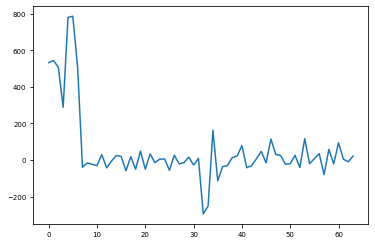

In [37]:
plt.plot(sarima_model.resid())

In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(test['call_v'], sarima_forecast)

6.327214328591678

In [39]:
from tbats import TBATS, BATS

estimator = TBATS(seasonal_periods = (7, 4))
tbats_model = estimator.fit(train['call_v'])

tbats_forecast = tbats_model.forecast(steps = len(test['call_v']))

In [40]:
print(tbats_model.summary())

Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: [4. 7.]
Seasonal harmonics [1 3]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000227
Smoothing (Alpha): 0.320150
Seasonal Parameters (Gamma): [-0.00412299  0.01369596 -0.01221776  0.01535062]
AR coefficients []
MA coefficients []
Seed vector [ 6.27023314 -0.0118204  -0.03466299  0.05560601 -0.11818488  0.07034613
 -0.23042771  0.28502526 -0.18487616]

AIC 822.504075


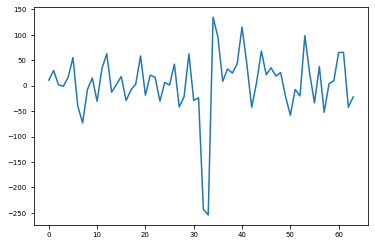

In [41]:
plt.plot(tbats_model.resid)

In [42]:
tbats_forecast_df = test

tbats_forecast_df['TBATS Forecast'] = tbats_forecast

tbats_forecast_df

C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,call_v,week,TBATS Forecast
64,2017-08-04,570,31,546.539083
65,2017-08-05,462,31,489.263957
66,2017-08-06,292,31,289.745363
67,2017-08-07,767,32,813.146381
68,2017-08-08,782,32,753.977664
69,2017-08-09,397,32,511.939423
70,2017-08-10,445,32,551.754932
71,2017-08-11,558,32,572.171522
72,2017-08-12,542,32,500.952304
73,2017-08-13,256,32,276.763241


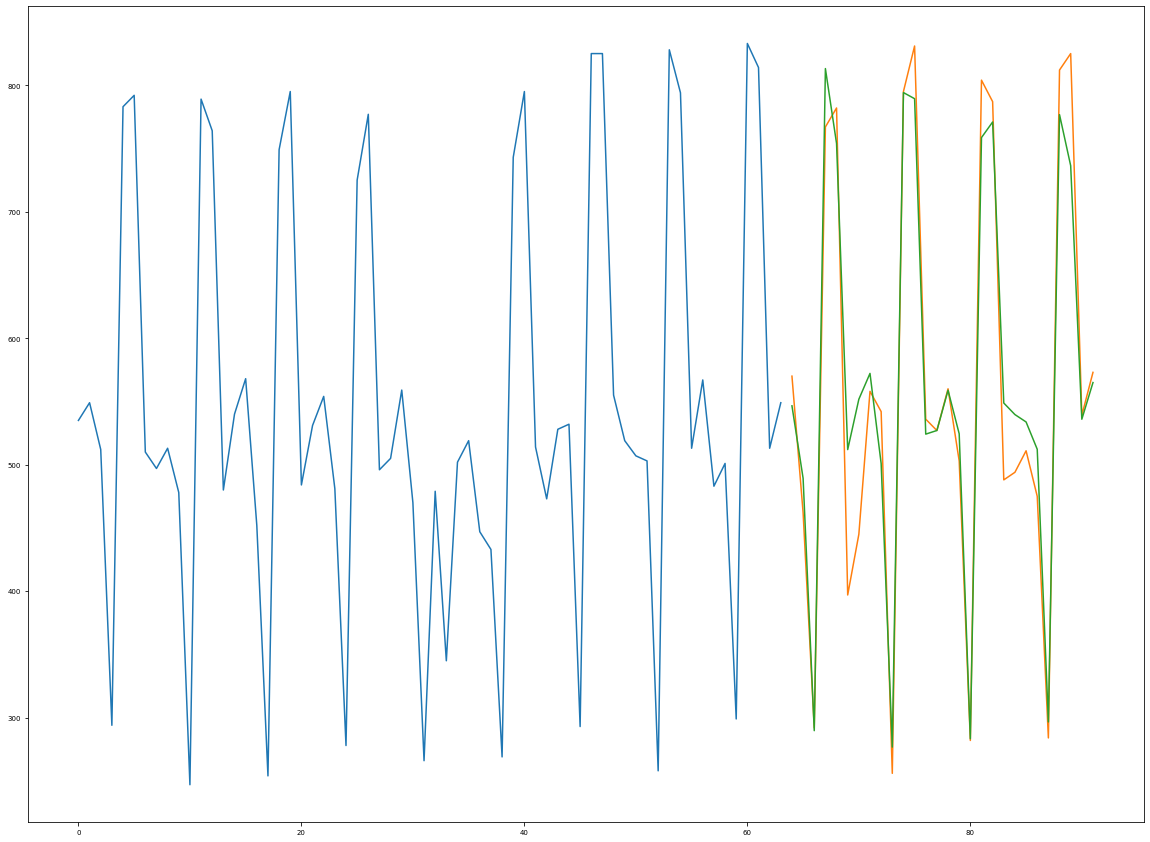

In [46]:
plt.figure(figsize=(20,15))
plt.plot(train['call_v'], label='Train')
plt.plot(test['call_v'], label='Test')
plt.plot(tbats_forecast_df['TBATS Forecast'], label = 'Forecast')
plt.show()

In [47]:
mean_absolute_percentage_error(test['call_v'], tbats_forecast)

5.965597470497303

### Forecasts

Both models (SARIMA and TBATS) perfrom relatively well in the in-sample forecast. We ran re-estimate now using the full sample and run true forecasts.

### SARIMA

In [54]:
f_sarima_model = auto_arima(ts_df['call_v'], trace = True, start_p = 0, d =0, start_q = 0,
                  max_p = 10, max_q = 10, m = 7, seasonal = True,
                  stepwise = True, suppress_warnings = True)

f_sarima_model.fit(ts_df['call_v'])

f_sarima_forecast = f_sarima_model.predict(n_periods= 30)

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(1, 1, 1, 7) (constant=True); AIC=974.738, BIC=984.509, Time=0.298 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=True); AIC=1010.539, BIC=1015.425, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 7) (constant=True); AIC=981.574, BIC=991.345, Time=0.111 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 7) (constant=True); AIC=951.667, BIC=961.437, Time=0.253 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=False); AIC=1008.542, BIC=1010.985, Time=0.009 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 7) (constant=True); AIC=973.208, BIC=980.536, Time=0.145 seconds
Near non-invertible roots for order (0, 0, 0)(0, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(1, 1, 0, 7) (constant=True); AIC=996.2

In [55]:
f_sarima_forecast

array([571.85318711, 507.2160622 , 293.99131689, 783.09527997,
       782.59948985, 522.30357746, 540.22100143, 554.78965889,
       509.99836547, 296.77362016, 785.87758323, 785.38179312,
       525.08588072, 543.0033047 , 557.57196215, 512.78066874,
       299.55592343, 788.6598865 , 788.16409638, 527.86818399,
       545.78560796, 560.35426542, 515.562972  , 302.33822669,
       791.44218977, 790.94639965, 530.65048726, 548.56791123,
       563.13656869, 518.34527527])

In [56]:
len(f_sarima_forecast)

30

In [57]:
date_max = ts_df['date'].max()
print('The data ranges at {}'.format(date_max))

The data ranges at 2017-08-31 00:00:00


In [70]:
backfill = list(ts_df['call_v'])

backfill_forecast = backfill + list(f_sarima_forecast)

len(backfill_forecast)

122

In [71]:
from datetime import datetime, timedelta

date_min = ts_df['date'].min()
date_max = ts_df['date'].max()
days = pd.date_range(date_min, date_max + timedelta(30), freq = 'D')
forecast_sarima = pd.DataFrame({'date': days, 'SARIMA Forecast':backfill_forecast})

forecast_sarima.head()

,date,SARIMA Forecast
0,2017-06-01,535.0
1,2017-06-02,549.0
2,2017-06-03,512.0
3,2017-06-04,294.0
4,2017-06-05,783.0


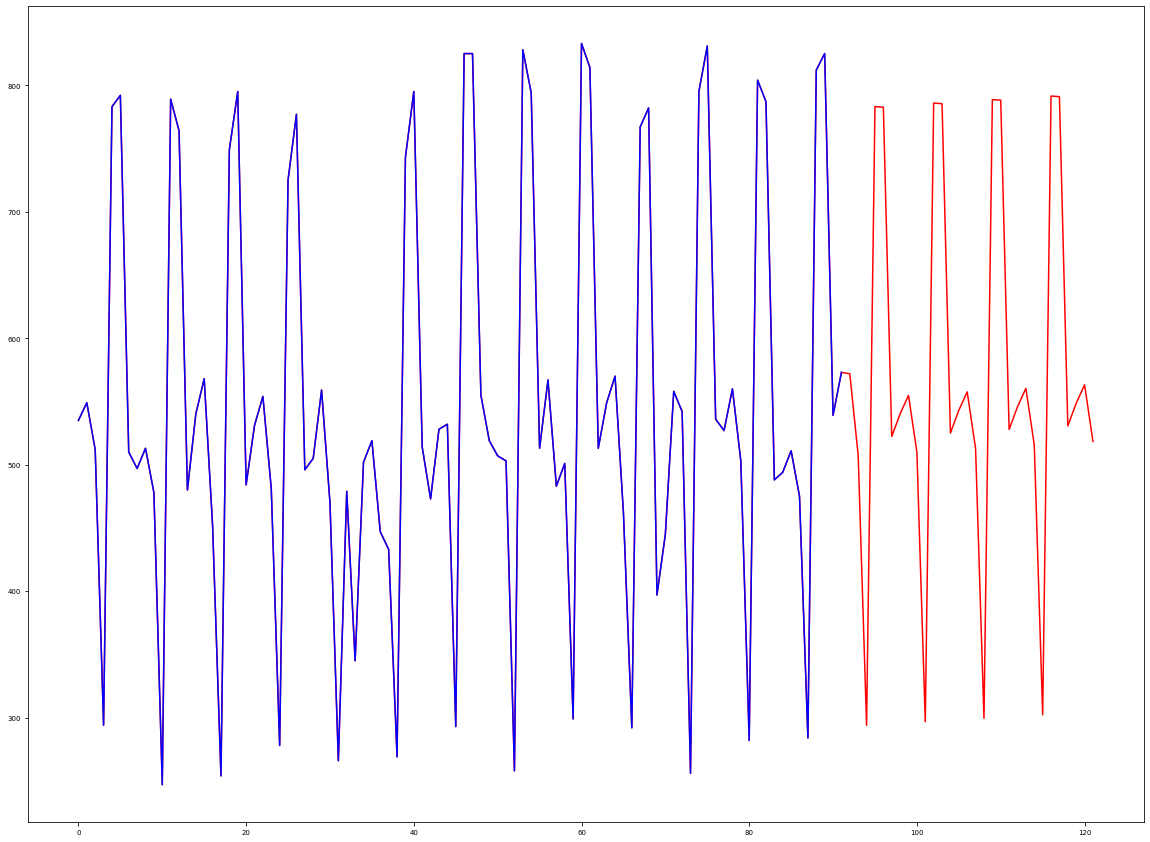

In [79]:
#plot the predictions for validation set
plt.figure(figsize = (20,15))
plt.plot(forecast_sarima['SARIMA Forecast'], label='Forecast', c = 'red')
plt.plot(ts_df['call_v'], label='Actualized Data', c = 'blue')
plt.show()

### TBATS Forecast

In [83]:
from tbats import TBATS, BATS

f_tbats_estimator = TBATS(seasonal_periods = (7, 4))
f_tbats_model = f_tbats_estimator.fit(ts_df['call_v'])

f_tbats_forecast = f_tbats_model.forecast(steps = 30)

In [84]:
print(f_tbats_forecast)
print(len(f_tbats_forecast))

[562.94582001 498.87826875 291.56248769 834.68950499 793.96035449
 512.20811866 550.49943609 585.95721155 515.60027517 280.11240494
 807.61876059 826.41486775 529.37693115 528.88052294 566.95338102
 536.67633505 289.50155201 775.90239778 799.61248733 551.01613585
 546.60818128 544.68829753 519.27078747 301.33543251 801.91003469
 768.2105425  533.14551823 568.95174336 562.94582001 498.87826875]
30


In [88]:
backfill_tbats_forecast = backfill + list(f_tbats_forecast)

len(backfill_tbats_forecast)

122

In [89]:
from datetime import datetime, timedelta

date_min = ts_df['date'].min()
date_max = ts_df['date'].max()
days = pd.date_range(date_min, date_max + timedelta(30), freq = 'D')
forecast_tbats = pd.DataFrame({'date': days, 'TBATS Forecast':backfill_tbats_forecast})

forecast_tbats.head()

,date,TBATS Forecast
0,2017-06-01,535.0
1,2017-06-02,549.0
2,2017-06-03,512.0
3,2017-06-04,294.0
4,2017-06-05,783.0


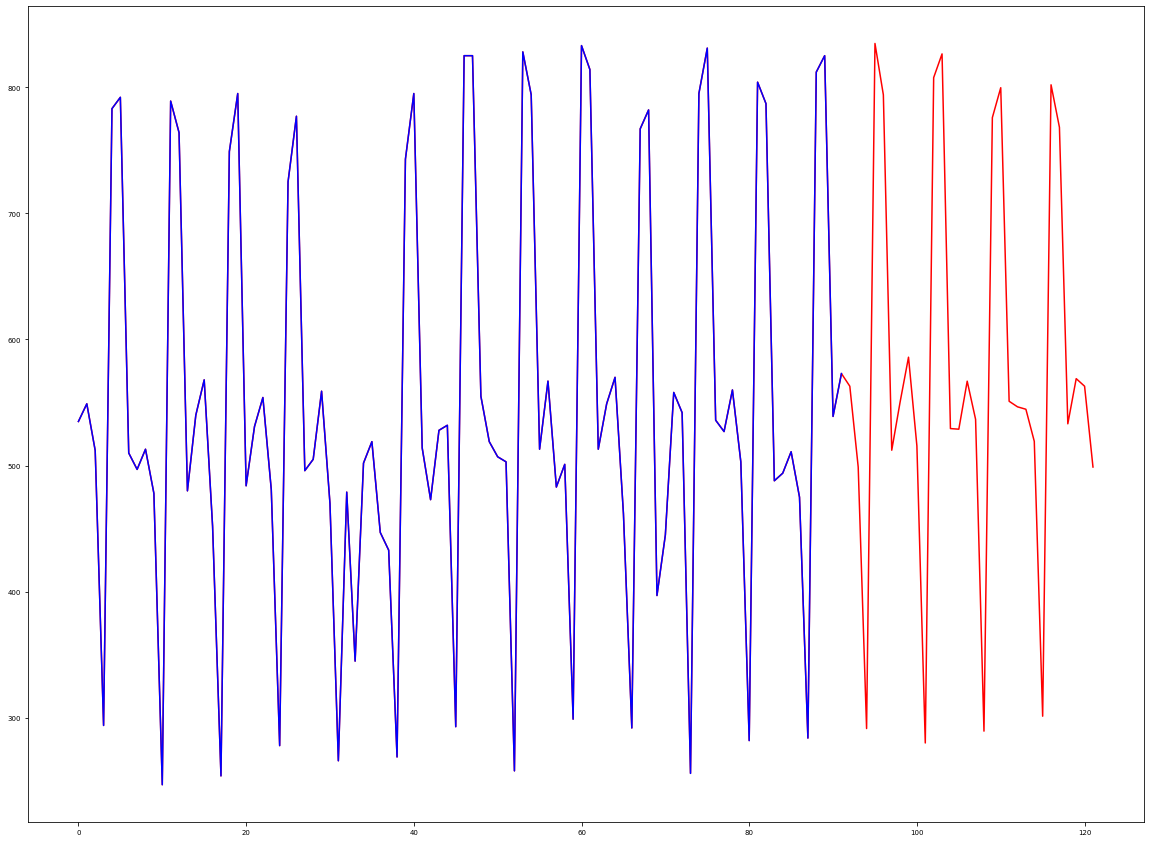

In [90]:
#plot the predictions for validation set
plt.figure(figsize = (20,15))
plt.plot(forecast_tbats['TBATS Forecast'], label='Forecast', c = 'red')
plt.plot(ts_df['call_v'], label='Actualized Data', c = 'blue')
plt.show()